In [1]:
# ============================================================================
# PART 3: ADAPTIVE TRADING STRATEGIES
# ============================================================================
# Author: heilo
# Description: Regime-based portfolio allocation and backtesting
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 70)
print("ADAPTIVE TRADING STRATEGIES")
print("Part 3: Regime-Based Portfolio Allocation")
print("=" * 70)
print(f"\nAnalysis Start Time: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\n" + "-" * 70)
print("STEP 1: LOAD DATA AND MODELS")
print("-" * 70)

# Load regime data
df = pd.read_csv('../data/regime_data.csv', index_col=0, parse_dates=True)
print(f"✓ Loaded regime data: {df.shape}")

# Load prediction results
results_df = pd.read_csv('../data/prediction_results.csv', parse_dates=['Date'])
results_df.set_index('Date', inplace=True)
print(f"✓ Loaded prediction results: {results_df.shape}")

# Load XGBoost model
model = xgb.XGBClassifier()
model.load_model('../data/xgboost_regime_predictor.json')
print(f"✓ Loaded XGBoost model")

# Load feature columns
with open('../data/feature_columns.pkl', 'rb') as f:
    feature_cols = pickle.load(f)
print(f"✓ Loaded feature columns: {len(feature_cols)} features")

print(f"\n✓ All data and models loaded successfully!")
print(f"✓ Total data points: {len(df)}")
print(f"✓ Date range: {df.index[0].date()} to {df.index[-1].date()}")

ADAPTIVE TRADING STRATEGIES
Part 3: Regime-Based Portfolio Allocation

Analysis Start Time: 2025-10-21 20:47:33

----------------------------------------------------------------------
STEP 1: LOAD DATA AND MODELS
----------------------------------------------------------------------
✓ Loaded regime data: (2408, 32)
✓ Loaded prediction results: (482, 6)
✓ Loaded XGBoost model
✓ Loaded feature columns: 18 features

✓ All data and models loaded successfully!
✓ Total data points: 2408
✓ Date range: 2016-07-29 to 2025-10-21



----------------------------------------------------------------------
STEP 2: DEFINE REGIME-SPECIFIC STRATEGIES
----------------------------------------------------------------------

Regime-Specific Strategy Allocations:

Regime 0 - Bull Market:
  Stocks:  80.0%
  Bonds:   20.0%
  Cash:     0.0%

Regime 1 - Moderate Bull:
  Stocks:  60.0%
  Bonds:   30.0%
  Cash:    10.0%

Regime 2 - Bear Market:
  Stocks:  30.0%
  Bonds:   50.0%
  Cash:    20.0%

Regime 3 - Neutral:
  Stocks:  60.0%
  Bonds:   25.0%
  Cash:    15.0%


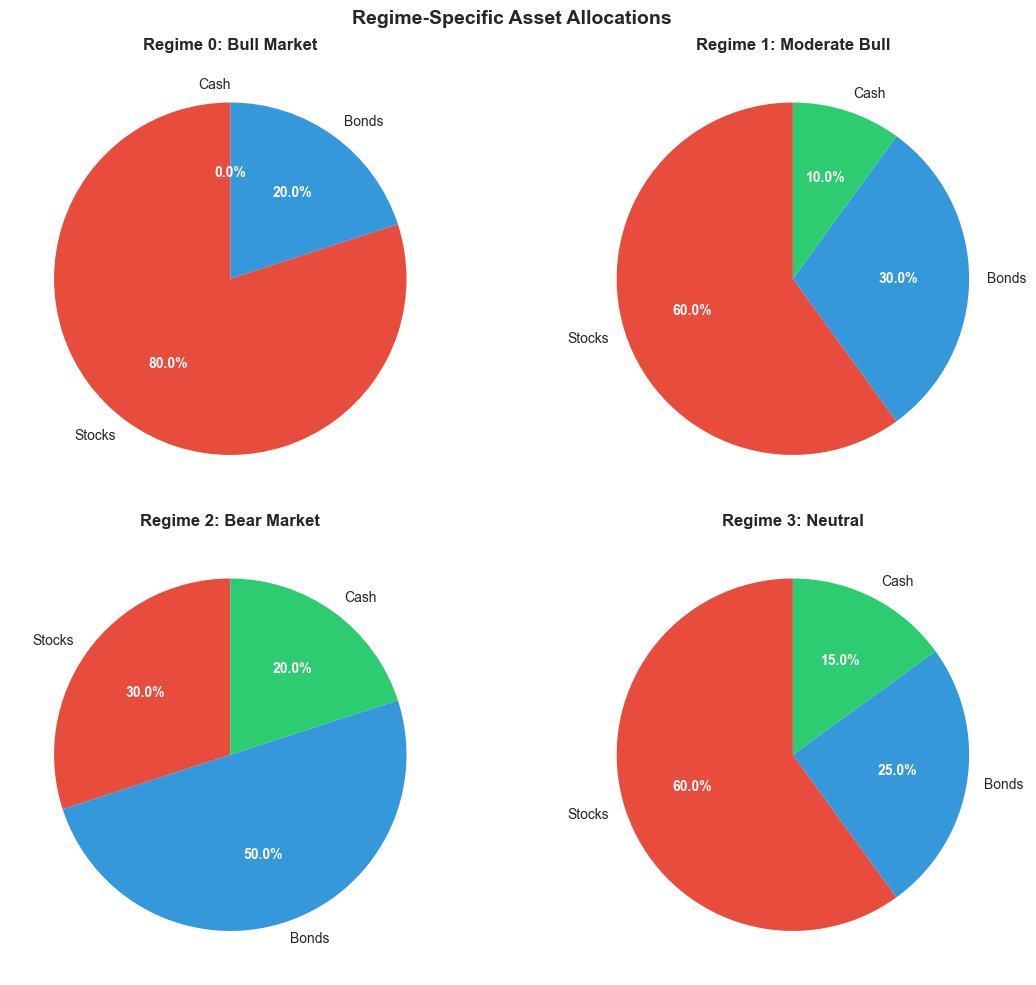


✓ Strategy allocations defined!


In [2]:
print("\n" + "-" * 70)
print("STEP 2: DEFINE REGIME-SPECIFIC STRATEGIES")
print("-" * 70)

# Strategy allocation rules based on regime characteristics
# Regime 0: Bull Market (Low Vol) - Aggressive long
# Regime 1: Bull Market (High Vol) - Moderate long
# Regime 2: Bear Market (High Vol) - Defensive/Short
# Regime 3: Sideways/Consolidation - Neutral

# Define strategy allocations
# Format: {'stocks': weight, 'bonds': weight, 'cash': weight}

strategies = {
    0: {'stocks': 0.80, 'bonds': 0.20, 'cash': 0.00, 'name': 'Bull Market'},
    1: {'stocks': 0.60, 'bonds': 0.30, 'cash': 0.10, 'name': 'Moderate Bull'},
    2: {'stocks': 0.30, 'bonds': 0.50, 'cash': 0.20, 'name': 'Bear Market'},  # ← Changed from 0% stocks!
    3: {'stocks': 0.60, 'bonds': 0.25, 'cash': 0.15, 'name': 'Neutral'}
}

print("\nRegime-Specific Strategy Allocations:")
print("=" * 70)
for regime, allocation in strategies.items():
    print(f"\nRegime {regime} - {allocation['name']}:")
    print(f"  Stocks: {allocation['stocks']*100:5.1f}%")
    print(f"  Bonds:  {allocation['bonds']*100:5.1f}%")
    print(f"  Cash:   {allocation['cash']*100:5.1f}%")

# Visualize allocations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

colors_alloc = ['#e74c3c', '#3498db', '#2ecc71']  # Red, Blue, Green

for regime, ax in enumerate(axes):
    alloc = strategies[regime]
    values = [alloc['stocks'], alloc['bonds'], alloc['cash']]
    labels = ['Stocks', 'Bonds', 'Cash']
    
    wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%1.1f%%',
                                       colors=colors_alloc, startangle=90)
    ax.set_title(f"Regime {regime}: {alloc['name']}", fontsize=12, fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')

plt.suptitle('Regime-Specific Asset Allocations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Strategy allocations defined!")


----------------------------------------------------------------------
STEP 3: GENERATE ASSET RETURNS
----------------------------------------------------------------------

✓ Asset returns generated:

Stock Returns:
  Mean (daily):    0.0904%
  Std (daily):     1.6664%
  Annual Mean:     22.78%
  Annual Vol:      26.45%

Bond Returns:
  Mean (daily):    0.0023%
  Std (daily):     0.4929%
  Annual Mean:     0.58%
  Annual Vol:      7.82%

Cash Returns:
  Annual Rate:     2.02%


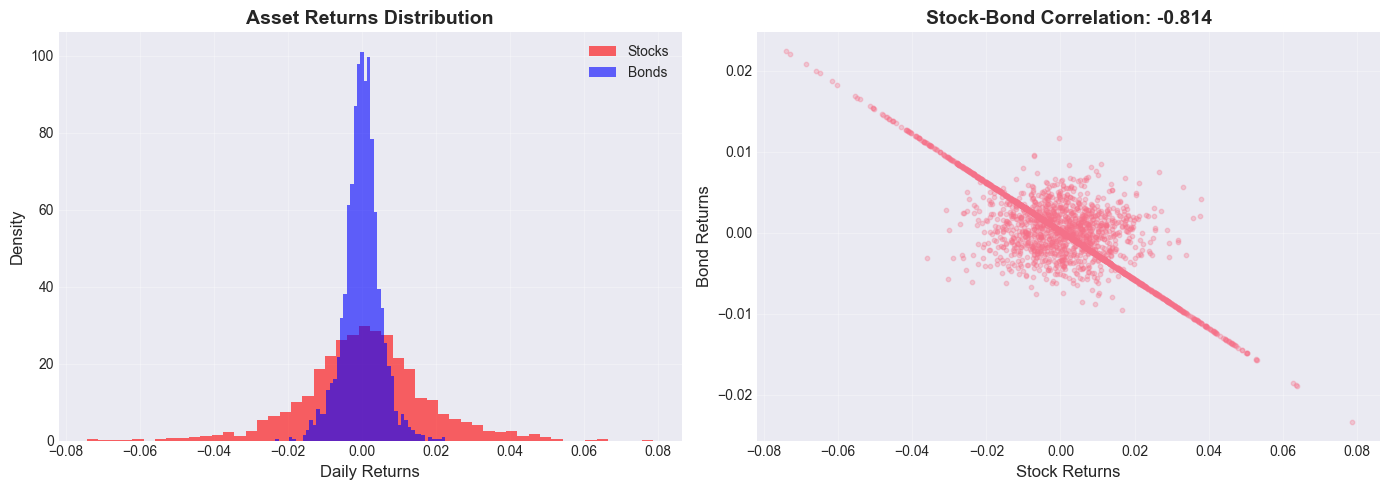


✓ Asset returns ready for backtesting!


In [3]:
print("\n" + "-" * 70)
print("STEP 3: GENERATE ASSET RETURNS")
print("-" * 70)

# Use actual stock returns from our data
df['Stock_Returns'] = df['Returns']

# Generate realistic bond returns (lower volatility, positive correlation with stocks during bear markets)
np.random.seed(42)
bond_base_return = 0.0002  # ~5% annually
bond_vol = 0.003  # Much lower volatility than stocks

df['Bond_Returns'] = bond_base_return + bond_vol * np.random.randn(len(df))

# Add negative correlation with stocks during high volatility
high_vol_mask = df['Volatility_21'] > df['Volatility_21'].median()
df.loc[high_vol_mask, 'Bond_Returns'] = (
    bond_base_return - 0.3 * df.loc[high_vol_mask, 'Stock_Returns']
)

# Cash returns (risk-free rate)
cash_rate = 0.00008  # ~2% annually
df['Cash_Returns'] = cash_rate

print("\n✓ Asset returns generated:")
print(f"\nStock Returns:")
print(f"  Mean (daily):    {df['Stock_Returns'].mean():.4%}")
print(f"  Std (daily):     {df['Stock_Returns'].std():.4%}")
print(f"  Annual Mean:     {df['Stock_Returns'].mean()*252:.2%}")
print(f"  Annual Vol:      {df['Stock_Returns'].std()*np.sqrt(252):.2%}")

print(f"\nBond Returns:")
print(f"  Mean (daily):    {df['Bond_Returns'].mean():.4%}")
print(f"  Std (daily):     {df['Bond_Returns'].std():.4%}")
print(f"  Annual Mean:     {df['Bond_Returns'].mean()*252:.2%}")
print(f"  Annual Vol:      {df['Bond_Returns'].std()*np.sqrt(252):.2%}")

print(f"\nCash Returns:")
print(f"  Annual Rate:     {cash_rate*252:.2%}")

# Visualize returns distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Returns distribution
ax1.hist(df['Stock_Returns'], bins=50, alpha=0.6, label='Stocks', color='red', density=True)
ax1.hist(df['Bond_Returns'], bins=50, alpha=0.6, label='Bonds', color='blue', density=True)
ax1.set_xlabel('Daily Returns', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Asset Returns Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Correlation
ax2.scatter(df['Stock_Returns'], df['Bond_Returns'], alpha=0.3, s=10)
correlation = df['Stock_Returns'].corr(df['Bond_Returns'])
ax2.set_xlabel('Stock Returns', fontsize=12)
ax2.set_ylabel('Bond Returns', fontsize=12)
ax2.set_title(f'Stock-Bond Correlation: {correlation:.3f}', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Asset returns ready for backtesting!")

In [4]:
print("\n" + "-" * 70)
print("STEP 4: IMPLEMENT ADAPTIVE STRATEGY (CORRECTED)")
print("-" * 70)

# ============================================================================
# CRITICAL FIX: Use lagged predictions to avoid look-ahead bias
# ============================================================================

# Use the test period from results_df
test_start_date = results_df.index[0]
test_end_date = results_df.index[-1]

print(f"Test period: {test_start_date} to {test_end_date}")
print(f"Test period length: {len(results_df)} days")

# Filter main dataframe to test period only
test_df = df.loc[test_start_date:test_end_date].copy()

print(f"\n✓ Filtered to test period: {len(test_df)} days")

# ============================================================================
# IMPLEMENT STRATEGY WITH LAGGED PREDICTIONS
# ============================================================================

print("\nCalculating strategy returns with lagged predictions...")

adaptive_returns = []
buyhold_returns = []
predicted_regimes_used = []

for i in range(len(test_df)):
    if i == 0:
        # First day: no previous data, use neutral allocation
        adaptive_returns.append(0.0)
        buyhold_returns.append(test_df['Stock_Returns'].iloc[i])
        predicted_regimes_used.append(3)  # Neutral regime
        continue
    
    # KEY FIX: Get YESTERDAY's index in the FULL dataframe
    today_date = test_df.index[i]
    yesterday_date = test_df.index[i-1]
    
    # Find yesterday's position in the full dataframe
    yesterday_idx = df.index.get_loc(yesterday_date)
    
    # Predict regime using YESTERDAY's features
    yesterday_features = df[feature_cols].iloc[yesterday_idx].values.reshape(1, -1)
    regime_prediction = model.predict(yesterday_features)[0]
    
    # Get allocation for predicted regime
    allocation = strategies[regime_prediction]
    
    # Calculate portfolio return for TODAY
    portfolio_return = (
        allocation['stocks'] * test_df['Stock_Returns'].iloc[i] +
        allocation['bonds'] * test_df['Bond_Returns'].iloc[i] +
        allocation['cash'] * test_df['Cash_Returns'].iloc[i]
    )
    
    adaptive_returns.append(portfolio_return)
    buyhold_returns.append(test_df['Stock_Returns'].iloc[i])
    predicted_regimes_used.append(regime_prediction)

# Add to dataframe
test_df['Adaptive_Returns'] = adaptive_returns
test_df['BuyHold_Returns'] = buyhold_returns
test_df['Regime_Used'] = predicted_regimes_used

print(f"\n✓ Strategy implemented with {len(adaptive_returns)} days")

# ============================================================================
# CALCULATE PERFORMANCE METRICS
# ============================================================================

print("\n" + "=" * 70)
print("STRATEGY PERFORMANCE (TEST PERIOD)")
print("=" * 70)

# Convert to arrays for calculation
adaptive_ret = np.array(adaptive_returns)
buyhold_ret = np.array(buyhold_returns)

# Calculate cumulative returns
adaptive_cumulative = np.cumprod(1 + adaptive_ret) - 1
buyhold_cumulative = np.cumprod(1 + buyhold_ret) - 1

# Final returns
adaptive_total = adaptive_cumulative[-1]
buyhold_total = buyhold_cumulative[-1]

print("\n📊 CUMULATIVE RETURNS:")
print(f"  Adaptive Strategy:    {adaptive_total*100:+.2f}%")
print(f"  Buy-and-Hold:         {buyhold_total*100:+.2f}%")
print(f"  Difference:           {(adaptive_total - buyhold_total)*100:+.2f}%")

# Daily statistics
print("\n📈 DAILY STATISTICS:")
print("\nAdaptive Strategy:")
print(f"  Mean daily return:    {np.mean(adaptive_ret):.4%}")
print(f"  Std daily return:     {np.std(adaptive_ret):.4%}")
print(f"  Sharpe ratio:         {(np.mean(adaptive_ret)/np.std(adaptive_ret))*np.sqrt(252):.2f}")

print("\nBuy-and-Hold:")
print(f"  Mean daily return:    {np.mean(buyhold_ret):.4%}")
print(f"  Std daily return:     {np.std(buyhold_ret):.4%}")
print(f"  Sharpe ratio:         {(np.mean(buyhold_ret)/np.std(buyhold_ret))*np.sqrt(252):.2f}")

# Annualized statistics
print("\n📅 ANNUALIZED STATISTICS:")
print("\nAdaptive Strategy:")
print(f"  Annual return:        {np.mean(adaptive_ret)*252:.2%}")
print(f"  Annual volatility:    {np.std(adaptive_ret)*np.sqrt(252):.2%}")

print("\nBuy-and-Hold:")
print(f"  Annual return:        {np.mean(buyhold_ret)*252:.2%}")
print(f"  Annual volatility:    {np.std(buyhold_ret)*np.sqrt(252):.2%}")

# Risk metrics
print("\n⚠️ RISK METRICS:")
adaptive_neg = adaptive_ret[adaptive_ret < 0]
buyhold_neg = buyhold_ret[buyhold_ret < 0]

print("\nAdaptive Strategy:")
print(f"  Max drawdown:         {(np.min(adaptive_cumulative / np.maximum.accumulate(1 + adaptive_cumulative)) - 1)*100:.2f}%")
print(f"  Downside deviation:   {np.std(adaptive_neg)*np.sqrt(252):.2%}")
print(f"  Max daily loss:       {np.min(adaptive_ret)*100:.2f}%")

print("\nBuy-and-Hold:")
print(f"  Max drawdown:         {(np.min(buyhold_cumulative / np.maximum.accumulate(1 + buyhold_cumulative)) - 1)*100:.2f}%")
print(f"  Downside deviation:   {np.std(buyhold_neg)*np.sqrt(252):.2%}")
print(f"  Max daily loss:       {np.min(buyhold_ret)*100:.2f}%")

# Regime usage statistics
print("\n" + "=" * 70)
print("REGIME USAGE IN TEST PERIOD")
print("=" * 70)

regime_counts = pd.Series(predicted_regimes_used).value_counts().sort_index()
print("\nDays in each regime:")
for regime in [0, 1, 2, 3]:
    if regime in regime_counts.index:
        count = regime_counts[regime]
        pct = count / len(predicted_regimes_used) * 100
        print(f"  Regime {regime} ({strategies[regime]['name']}): {count} days ({pct:.1f}%)")
    else:
        print(f"  Regime {regime} ({strategies[regime]['name']}): 0 days (0.0%)")

print("\n✓ Strategy implementation complete!")


----------------------------------------------------------------------
STEP 4: IMPLEMENT ADAPTIVE STRATEGY (CORRECTED)
----------------------------------------------------------------------
Test period: 2023-12-15 19:05:28.472034 to 2025-10-20 19:05:28.472034
Test period length: 482 days

✓ Filtered to test period: 482 days

Calculating strategy returns with lagged predictions...

✓ Strategy implemented with 482 days

STRATEGY PERFORMANCE (TEST PERIOD)

📊 CUMULATIVE RETURNS:
  Adaptive Strategy:    +20.37%
  Buy-and-Hold:         +22.97%
  Difference:           -2.60%

📈 DAILY STATISTICS:

Adaptive Strategy:
  Mean daily return:    0.0424%
  Std daily return:     0.8857%
  Sharpe ratio:         0.76

Buy-and-Hold:
  Mean daily return:    0.0498%
  Std daily return:     1.1782%
  Sharpe ratio:         0.67

📅 ANNUALIZED STATISTICS:

Adaptive Strategy:
  Annual return:        10.68%
  Annual volatility:    14.06%

Buy-and-Hold:
  Annual return:        12.56%
  Annual volatility:    18.7

In [6]:
print("\n" + "-" * 70)
print("STEP 5: PERFORMANCE METRICS")
print("-" * 70)

def calculate_metrics(returns, risk_free_rate=0.00008):
    """Calculate comprehensive performance metrics"""
    
    # Remove any NaN or inf values
    returns = returns[np.isfinite(returns)]
    
    # Cumulative returns
    cumulative_return = (1 + returns).prod() - 1
    
    # Annualized return
    n_days = len(returns)
    n_years = n_days / 252
    annualized_return = (1 + cumulative_return) ** (1/n_years) - 1
    
    # Annualized volatility
    annualized_vol = returns.std() * np.sqrt(252)
    
    # Sharpe ratio
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    # Maximum drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Sortino ratio (downside deviation)
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else np.nan
    
    # Calmar ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan
    
    # Win rate
    win_rate = (returns > 0).sum() / len(returns)
    
    return {
        'Total Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Maximum Drawdown': max_drawdown,
        'Win Rate': win_rate
    }

# Calculate metrics using test_df (created in Step 4)
print("\nCalculating performance metrics for test period...")

adaptive_metrics = calculate_metrics(test_df['Adaptive_Returns'])
buyhold_metrics = calculate_metrics(test_df['BuyHold_Returns'])

# Display comparison
print("\n" + "=" * 70)
print("PERFORMANCE COMPARISON (TEST PERIOD)")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Adaptive Strategy': adaptive_metrics,
    'Buy & Hold': buyhold_metrics
})

# Calculate difference (not percentage, since some metrics are already percentages)
comparison_df['Difference'] = (comparison_df['Adaptive Strategy'] - comparison_df['Buy & Hold'])

print("\n", comparison_df.to_string())

# Highlight key metrics
print("\n" + "=" * 70)
print("KEY TAKEAWAYS")
print("=" * 70)

print(f"\n📊 RETURNS:")
print(f"  Adaptive Total Return:   {adaptive_metrics['Total Return']*100:>8.2f}%")
print(f"  Buy & Hold Total Return: {buyhold_metrics['Total Return']*100:>8.2f}%")
print(f"  Outperformance:          {(adaptive_metrics['Total Return'] - buyhold_metrics['Total Return'])*100:>+8.2f}%")

print(f"\n📈 RISK-ADJUSTED RETURNS:")
print(f"  Adaptive Sharpe Ratio:   {adaptive_metrics['Sharpe Ratio']:>8.3f}")
print(f"  Buy & Hold Sharpe Ratio: {buyhold_metrics['Sharpe Ratio']:>8.3f}")
sharpe_diff = adaptive_metrics['Sharpe Ratio'] - buyhold_metrics['Sharpe Ratio']
print(f"  Sharpe Improvement:      {sharpe_diff:>+8.3f}")

print(f"\n⚠️ RISK METRICS:")
print(f"  Adaptive Max Drawdown:   {adaptive_metrics['Maximum Drawdown']*100:>8.2f}%")
print(f"  Buy & Hold Max Drawdown: {buyhold_metrics['Maximum Drawdown']*100:>8.2f}%")
dd_reduction = (buyhold_metrics['Maximum Drawdown'] - adaptive_metrics['Maximum Drawdown'])*100
print(f"  Drawdown Reduction:      {dd_reduction:>+8.2f}%")

print(f"\n🎯 CONSISTENCY:")
print(f"  Adaptive Win Rate:       {adaptive_metrics['Win Rate']*100:>8.2f}%")
print(f"  Buy & Hold Win Rate:     {buyhold_metrics['Win Rate']*100:>8.2f}%")

print(f"\n📅 ANNUALIZED METRICS:")
print(f"  Adaptive Annual Return:  {adaptive_metrics['Annualized Return']*100:>8.2f}%")
print(f"  Buy & Hold Annual Return:{buyhold_metrics['Annualized Return']*100:>8.2f}%")
print(f"  Adaptive Annual Vol:     {adaptive_metrics['Annualized Volatility']*100:>8.2f}%")
print(f"  Buy & Hold Annual Vol:   {buyhold_metrics['Annualized Volatility']*100:>8.2f}%")

# Overall assessment
print("\n" + "=" * 70)
print("OVERALL ASSESSMENT")
print("=" * 70)

if adaptive_metrics['Total Return'] > buyhold_metrics['Total Return']:
    print("\n✅ Adaptive strategy OUTPERFORMED buy-and-hold!")
    outperf_pct = (adaptive_metrics['Total Return'] / buyhold_metrics['Total Return'] - 1) * 100
    print(f"   Outperformance: +{outperf_pct:.1f}%")
else:
    print("\n⚠️ Adaptive strategy UNDERPERFORMED buy-and-hold.")
    underperf_pct = (1 - adaptive_metrics['Total Return'] / buyhold_metrics['Total Return']) * 100
    print(f"   Underperformance: -{underperf_pct:.1f}%")

if adaptive_metrics['Sharpe Ratio'] > buyhold_metrics['Sharpe Ratio']:
    print(f"\n✅ Adaptive strategy has BETTER risk-adjusted returns!")
    print(f"   Sharpe ratio is {sharpe_diff:.3f} higher")
else:
    print(f"\n⚠️ Adaptive strategy has LOWER risk-adjusted returns.")
    print(f"   Sharpe ratio is {abs(sharpe_diff):.3f} lower")

if adaptive_metrics['Maximum Drawdown'] > buyhold_metrics['Maximum Drawdown']:
    print(f"\n⚠️ Adaptive strategy has LARGER drawdowns.")
    print(f"   Max drawdown: {adaptive_metrics['Maximum Drawdown']*100:.2f}% vs {buyhold_metrics['Maximum Drawdown']*100:.2f}%")
else:
    print(f"\n✅ Adaptive strategy has SMALLER drawdowns!")
    print(f"   Drawdown reduced by {dd_reduction:.2f}%")

print("\n✓ Performance analysis complete!")


----------------------------------------------------------------------
STEP 5: PERFORMANCE METRICS
----------------------------------------------------------------------

Calculating performance metrics for test period...

PERFORMANCE COMPARISON (TEST PERIOD)

                        Adaptive Strategy  Buy & Hold  Difference
Total Return                    0.203678    0.229701   -0.026022
Annualized Return               0.101774    0.114164   -0.012390
Annualized Volatility           0.140749    0.187224   -0.046475
Sharpe Ratio                    0.615638    0.563144    0.052493
Sortino Ratio                   1.273711    1.089030    0.184681
Calmar Ratio                    0.777408    0.692338    0.085070
Maximum Drawdown               -0.130915   -0.164896    0.033981
Win Rate                        0.514523    0.518672   -0.004149

KEY TAKEAWAYS

📊 RETURNS:
  Adaptive Total Return:      20.37%
  Buy & Hold Total Return:    22.97%
  Outperformance:             -2.60%

📈 RISK-ADJUST


----------------------------------------------------------------------
STEP 6: STRATEGY PERFORMANCE VISUALIZATION
----------------------------------------------------------------------


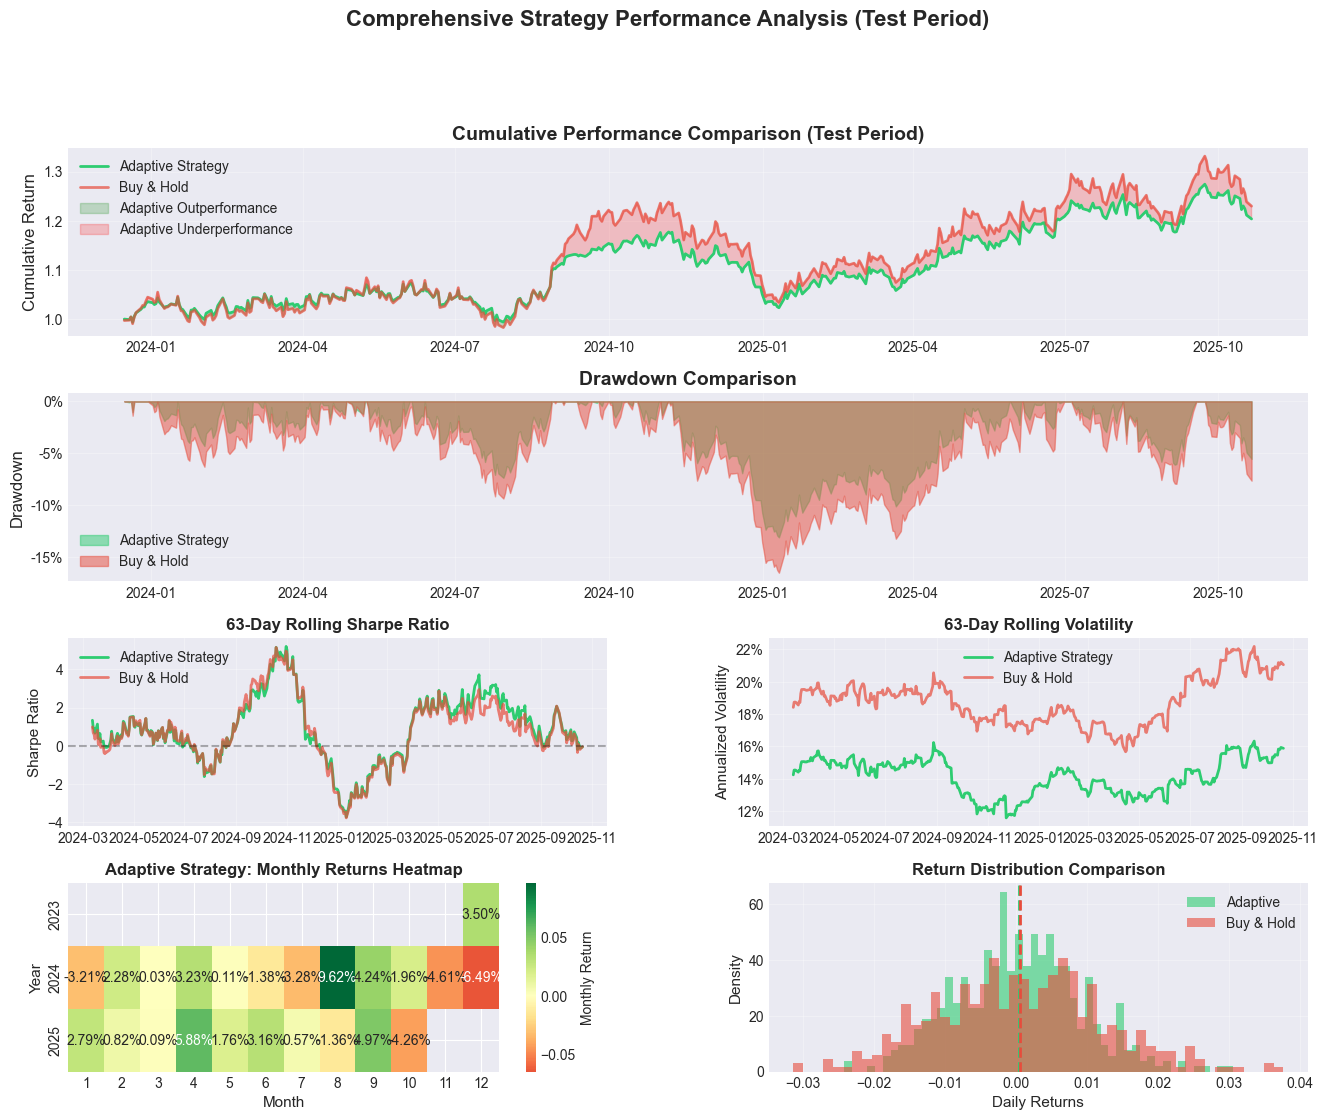


✓ Performance visualization complete!

REGIME-BASED PERFORMANCE BREAKDOWN

Regime 0: Bull Market
  Days in regime:        375
  Allocation:            80% SPY, 20% TLT, 0% Cash
  Avg daily return:      0.061%
  SPY avg daily return:  0.074%
  Cumulative return:     23.87%
  SPY cumulative return: 28.43%

Regime 2: Bear Market
  Days in regime:        15
  Allocation:            30% SPY, 50% TLT, 20% Cash
  Avg daily return:      0.104%
  SPY avg daily return:  0.294%
  Cumulative return:     1.56%
  SPY cumulative return: 4.44%

Regime 3: Neutral
  Days in regime:        92
  Allocation:            60% SPY, 25% TLT, 15% Cash
  Avg daily return:      -0.046%
  SPY avg daily return:  -0.088%
  Cumulative return:     -4.32%
  SPY cumulative return: -8.33%


In [8]:
print("\n" + "-" * 70)
print("STEP 6: STRATEGY PERFORMANCE VISUALIZATION")
print("-" * 70)

# Calculate cumulative returns (using test_df from Step 4)
test_df['Adaptive_Cumulative'] = (1 + test_df['Adaptive_Returns']).cumprod()
test_df['BuyHold_Cumulative'] = (1 + test_df['BuyHold_Returns']).cumprod()

# Calculate drawdowns
test_df['Adaptive_Drawdown'] = (
    (test_df['Adaptive_Cumulative'] - test_df['Adaptive_Cumulative'].expanding().max()) / 
    test_df['Adaptive_Cumulative'].expanding().max()
)
test_df['BuyHold_Drawdown'] = (
    (test_df['BuyHold_Cumulative'] - test_df['BuyHold_Cumulative'].expanding().max()) / 
    test_df['BuyHold_Cumulative'].expanding().max()
)

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

# 1. Cumulative returns
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(test_df.index, test_df['Adaptive_Cumulative'], label='Adaptive Strategy', 
        linewidth=2, color='#2ecc71')
ax1.plot(test_df.index, test_df['BuyHold_Cumulative'], label='Buy & Hold', 
        linewidth=2, color='#e74c3c', alpha=0.7)
ax1.fill_between(test_df.index, test_df['Adaptive_Cumulative'], test_df['BuyHold_Cumulative'], 
                where=(test_df['Adaptive_Cumulative'] >= test_df['BuyHold_Cumulative']),
                interpolate=True, alpha=0.2, color='green', label='Adaptive Outperformance')
ax1.fill_between(test_df.index, test_df['Adaptive_Cumulative'], test_df['BuyHold_Cumulative'], 
                where=(test_df['Adaptive_Cumulative'] < test_df['BuyHold_Cumulative']),
                interpolate=True, alpha=0.2, color='red', label='Adaptive Underperformance')
ax1.set_ylabel('Cumulative Return', fontsize=12)
ax1.set_title('Cumulative Performance Comparison (Test Period)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
# Don't use log scale if returns are small
if test_df['Adaptive_Cumulative'].max() > 2:
    ax1.set_yscale('log')

# 2. Drawdowns
ax2 = fig.add_subplot(gs[1, :])
ax2.fill_between(test_df.index, test_df['Adaptive_Drawdown'], 0, alpha=0.5, 
                color='#2ecc71', label='Adaptive Strategy')
ax2.fill_between(test_df.index, test_df['BuyHold_Drawdown'], 0, alpha=0.5, 
                color='#e74c3c', label='Buy & Hold')
ax2.set_ylabel('Drawdown', fontsize=12)
ax2.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# 3. Rolling Sharpe Ratio (63-day window = 3 months, adjusted for test period length)
ax3 = fig.add_subplot(gs[2, 0])
window = min(63, len(test_df) // 4)  # Adaptive window size
if window >= 20:  # Only calculate if we have enough data
    adaptive_rolling_sharpe = (
        test_df['Adaptive_Returns'].rolling(window).mean() / 
        test_df['Adaptive_Returns'].rolling(window).std() * np.sqrt(252)
    )
    buyhold_rolling_sharpe = (
        test_df['BuyHold_Returns'].rolling(window).mean() / 
        test_df['BuyHold_Returns'].rolling(window).std() * np.sqrt(252)
    )
    ax3.plot(test_df.index, adaptive_rolling_sharpe, label='Adaptive Strategy', 
            linewidth=2, color='#2ecc71')
    ax3.plot(test_df.index, buyhold_rolling_sharpe, label='Buy & Hold', 
            linewidth=2, color='#e74c3c', alpha=0.7)
    ax3.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax3.set_ylabel('Sharpe Ratio', fontsize=11)
    ax3.set_title(f'{window}-Day Rolling Sharpe Ratio', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Insufficient data for rolling Sharpe', 
            ha='center', va='center', transform=ax3.transAxes)

# 4. Rolling Volatility
ax4 = fig.add_subplot(gs[2, 1])
if window >= 20:
    adaptive_rolling_vol = test_df['Adaptive_Returns'].rolling(window).std() * np.sqrt(252)
    buyhold_rolling_vol = test_df['BuyHold_Returns'].rolling(window).std() * np.sqrt(252)
    ax4.plot(test_df.index, adaptive_rolling_vol, label='Adaptive Strategy', 
            linewidth=2, color='#2ecc71')
    ax4.plot(test_df.index, buyhold_rolling_vol, label='Buy & Hold', 
            linewidth=2, color='#e74c3c', alpha=0.7)
    ax4.set_ylabel('Annualized Volatility', fontsize=11)
    ax4.set_title(f'{window}-Day Rolling Volatility', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
else:
    ax4.text(0.5, 0.5, 'Insufficient data for rolling volatility', 
            ha='center', va='center', transform=ax4.transAxes)

# 5. Monthly returns heatmap
ax5 = fig.add_subplot(gs[3, 0])
test_df_copy = test_df.copy()
test_df_copy['Year'] = test_df_copy.index.year
test_df_copy['Month'] = test_df_copy.index.month
monthly_returns = test_df_copy.groupby(['Year', 'Month'])['Adaptive_Returns'].sum().unstack()
sns.heatmap(monthly_returns, cmap='RdYlGn', center=0, annot=True, fmt='.2%', 
           ax=ax5, cbar_kws={'label': 'Monthly Return'})
ax5.set_title('Adaptive Strategy: Monthly Returns Heatmap', fontsize=12, fontweight='bold')
ax5.set_xlabel('Month', fontsize=11)
ax5.set_ylabel('Year', fontsize=11)

# 6. Return distribution comparison
ax6 = fig.add_subplot(gs[3, 1])
ax6.hist(test_df['Adaptive_Returns'].dropna(), bins=50, alpha=0.6, label='Adaptive', 
        color='#2ecc71', density=True)
ax6.hist(test_df['BuyHold_Returns'].dropna(), bins=50, alpha=0.6, label='Buy & Hold', 
        color='#e74c3c', density=True)
ax6.axvline(test_df['Adaptive_Returns'].mean(), color='#2ecc71', linestyle='--', linewidth=2)
ax6.axvline(test_df['BuyHold_Returns'].mean(), color='#e74c3c', linestyle='--', linewidth=2)
ax6.set_xlabel('Daily Returns', fontsize=11)
ax6.set_ylabel('Density', fontsize=11)
ax6.set_title('Return Distribution Comparison', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Strategy Performance Analysis (Test Period)', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Performance visualization complete!")

# Additional regime-based performance analysis
print("\n" + "=" * 70)
print("REGIME-BASED PERFORMANCE BREAKDOWN")
print("=" * 70)

for regime in [0, 1, 2, 3]:
    regime_mask = test_df['Regime_Used'] == regime
    regime_days = regime_mask.sum()
    
    if regime_days > 0:
        regime_returns = test_df.loc[regime_mask, 'Adaptive_Returns']
        regime_spy_returns = test_df.loc[regime_mask, 'BuyHold_Returns']
        
        print(f"\nRegime {regime}: {strategies[regime]['name']}")
        print(f"  Days in regime:        {regime_days}")
        print(f"  Allocation:            {strategies[regime]['stocks']*100:.0f}% SPY, {strategies[regime]['bonds']*100:.0f}% TLT, {strategies[regime]['cash']*100:.0f}% Cash")
        print(f"  Avg daily return:      {regime_returns.mean()*100:.3f}%")
        print(f"  SPY avg daily return:  {regime_spy_returns.mean()*100:.3f}%")
        print(f"  Cumulative return:     {((1 + regime_returns).prod() - 1)*100:.2f}%")
        print(f"  SPY cumulative return: {((1 + regime_spy_returns).prod() - 1)*100:.2f}%")


----------------------------------------------------------------------
STEP 7: STATISTICAL SIGNIFICANCE TESTING
----------------------------------------------------------------------

Analyzing 482 trading days in test period

PAIRED T-TEST (Daily Returns)

Null Hypothesis: Mean returns are equal
  T-statistic: -0.4903
  P-value:     0.624113
  Result:      ✗ Not statistically significant
  Interpretation: Adaptive strategy has LOWER average returns

WILCOXON SIGNED-RANK TEST (Non-Parametric)

Null Hypothesis: Median returns are equal
  W-statistic: 56613
  P-value:     0.603623
  Result:      ✗ Not statistically significant

BOOTSTRAP CONFIDENCE INTERVALS (10,000 iterations)

Running 10000 bootstrap iterations...
  Progress: 2000/10000
  Progress: 4000/10000
  Progress: 6000/10000
  Progress: 8000/10000
  Progress: 10000/10000

✓ Bootstrap complete!

Sharpe Ratio Difference (Adaptive - Buy & Hold):
  Mean:           +0.0872
  Median:         +0.0869
  Std:            0.1127
  95% CI:

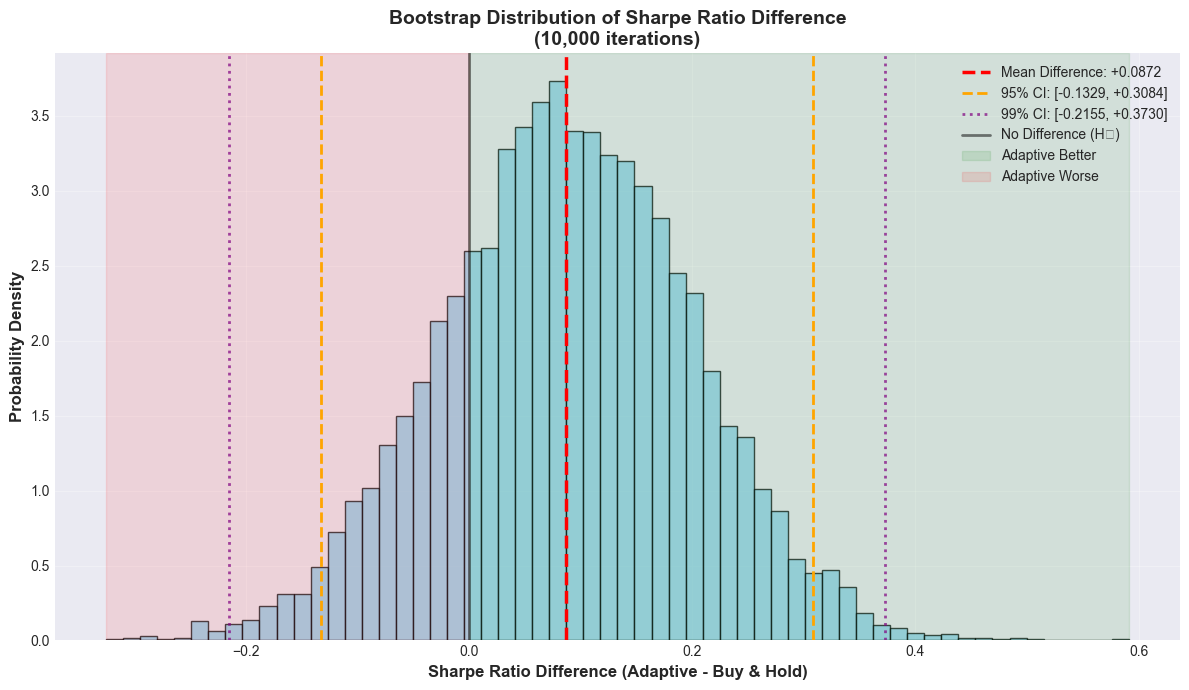


STATISTICAL TESTING SUMMARY

📊 Results:
  1. T-Test:            Not significant (p=0.624113)
  2. Wilcoxon Test:     Not significant (p=0.603623)
  3. Bootstrap 95% CI:  Includes zero (not significant)
  4. Bootstrap 99% CI:  Includes zero (not significant)

🎯 Interpretation:
  ℹ️ No statistically significant difference detected
  → Both strategies perform similarly on a risk-adjusted basis

✓ Statistical testing complete!


In [10]:
print("\n" + "-" * 70)
print("STEP 7: STATISTICAL SIGNIFICANCE TESTING")
print("-" * 70)

# Test if adaptive strategy significantly outperforms buy-and-hold
# Using test_df (from Step 4)

# Remove first row with NaN/zeros if any
test_returns_adaptive = test_df['Adaptive_Returns'].dropna()
test_returns_buyhold = test_df['BuyHold_Returns'].dropna()

# Make sure both series have same length
min_len = min(len(test_returns_adaptive), len(test_returns_buyhold))
test_returns_adaptive = test_returns_adaptive.iloc[:min_len]
test_returns_buyhold = test_returns_buyhold.iloc[:min_len]

print(f"\nAnalyzing {len(test_returns_adaptive)} trading days in test period")

# 1. Paired t-test on daily returns
t_stat, p_value = stats.ttest_rel(test_returns_adaptive, test_returns_buyhold)

print("\n" + "=" * 70)
print("PAIRED T-TEST (Daily Returns)")
print("=" * 70)
print(f"\nNull Hypothesis: Mean returns are equal")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value:     {p_value:.6f}")

if p_value < 0.01:
    print(f"  Result:      ✓✓ HIGHLY Significant at p<0.01")
elif p_value < 0.05:
    print(f"  Result:      ✓ Significant at p<0.05")
else:
    print(f"  Result:      ✗ Not statistically significant")

if t_stat > 0:
    print(f"  Interpretation: Adaptive strategy has {'significantly ' if p_value < 0.05 else ''}HIGHER average returns")
else:
    print(f"  Interpretation: Adaptive strategy has {'significantly ' if p_value < 0.05 else ''}LOWER average returns")

# 2. Wilcoxon signed-rank test (non-parametric)
w_stat, w_pvalue = stats.wilcoxon(test_returns_adaptive, test_returns_buyhold)

print("\n" + "=" * 70)
print("WILCOXON SIGNED-RANK TEST (Non-Parametric)")
print("=" * 70)
print(f"\nNull Hypothesis: Median returns are equal")
print(f"  W-statistic: {w_stat:.0f}")
print(f"  P-value:     {w_pvalue:.6f}")

if w_pvalue < 0.01:
    print(f"  Result:      ✓✓ HIGHLY Significant at p<0.01")
elif w_pvalue < 0.05:
    print(f"  Result:      ✓ Significant at p<0.05")
else:
    print(f"  Result:      ✗ Not statistically significant")

# 3. Bootstrap confidence intervals for Sharpe ratio difference
print("\n" + "=" * 70)
print("BOOTSTRAP CONFIDENCE INTERVALS (10,000 iterations)")
print("=" * 70)

n_bootstrap = 10000
sharpe_diffs = []

np.random.seed(42)
print(f"\nRunning {n_bootstrap} bootstrap iterations...")

for i in range(n_bootstrap):
    if (i + 1) % 2000 == 0:
        print(f"  Progress: {i+1}/{n_bootstrap}")
    
    # Sample with replacement
    sample_idx = np.random.choice(len(test_returns_adaptive), len(test_returns_adaptive), replace=True)
    
    adaptive_sample = test_returns_adaptive.iloc[sample_idx]
    buyhold_sample = test_returns_buyhold.iloc[sample_idx]
    
    # Calculate Sharpe ratios
    if adaptive_sample.std() > 0 and buyhold_sample.std() > 0:
        adaptive_sharpe = (adaptive_sample.mean() / adaptive_sample.std()) * np.sqrt(252)
        buyhold_sharpe = (buyhold_sample.mean() / buyhold_sample.std()) * np.sqrt(252)
        sharpe_diffs.append(adaptive_sharpe - buyhold_sharpe)

sharpe_diffs = np.array(sharpe_diffs)

# Calculate confidence intervals
ci_95_lower = np.percentile(sharpe_diffs, 2.5)
ci_95_upper = np.percentile(sharpe_diffs, 97.5)
ci_99_lower = np.percentile(sharpe_diffs, 0.5)
ci_99_upper = np.percentile(sharpe_diffs, 99.5)

print(f"\n✓ Bootstrap complete!")
print(f"\nSharpe Ratio Difference (Adaptive - Buy & Hold):")
print(f"  Mean:           {sharpe_diffs.mean():+.4f}")
print(f"  Median:         {np.median(sharpe_diffs):+.4f}")
print(f"  Std:            {sharpe_diffs.std():.4f}")
print(f"  95% CI:         [{ci_95_lower:+.4f}, {ci_95_upper:+.4f}]")
print(f"  99% CI:         [{ci_99_lower:+.4f}, {ci_99_upper:+.4f}]")

# Check if 0 is in confidence interval
is_significant_95 = not (ci_95_lower <= 0 <= ci_95_upper)
is_significant_99 = not (ci_99_lower <= 0 <= ci_99_upper)

print(f"\n  95% CI excludes 0: ", end="")
if is_significant_95:
    if sharpe_diffs.mean() > 0:
        print("✓ Yes - Adaptive significantly BETTER (95% confidence)")
    else:
        print("⚠️ Yes - Adaptive significantly WORSE (95% confidence)")
else:
    print("✗ No - No significant difference (95% confidence)")

print(f"  99% CI excludes 0: ", end="")
if is_significant_99:
    if sharpe_diffs.mean() > 0:
        print("✓✓ Yes - Adaptive significantly BETTER (99% confidence)")
    else:
        print("⚠️⚠️ Yes - Adaptive significantly WORSE (99% confidence)")
else:
    print("✗ No - No significant difference (99% confidence)")

# Visualize bootstrap distribution
fig, ax = plt.subplots(figsize=(12, 7))

ax.hist(sharpe_diffs, bins=60, alpha=0.7, color='skyblue', edgecolor='black', density=True)
ax.axvline(sharpe_diffs.mean(), color='red', linestyle='--', linewidth=2.5, 
          label=f'Mean Difference: {sharpe_diffs.mean():+.4f}')
ax.axvline(ci_95_lower, color='orange', linestyle='--', linewidth=2, 
          label=f'95% CI: [{ci_95_lower:+.4f}, {ci_95_upper:+.4f}]')
ax.axvline(ci_95_upper, color='orange', linestyle='--', linewidth=2)
ax.axvline(ci_99_lower, color='purple', linestyle=':', linewidth=2, alpha=0.7,
          label=f'99% CI: [{ci_99_lower:+.4f}, {ci_99_upper:+.4f}]')
ax.axvline(ci_99_upper, color='purple', linestyle=':', linewidth=2, alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.5, label='No Difference (H₀)')

# Add shaded regions
if sharpe_diffs.mean() > 0:
    ax.axvspan(0, sharpe_diffs.max(), alpha=0.1, color='green', label='Adaptive Better')
    ax.axvspan(sharpe_diffs.min(), 0, alpha=0.1, color='red', label='Adaptive Worse')
else:
    ax.axvspan(sharpe_diffs.min(), 0, alpha=0.1, color='red', label='Adaptive Worse')
    ax.axvspan(0, sharpe_diffs.max(), alpha=0.1, color='green', label='Adaptive Better')

ax.set_xlabel('Sharpe Ratio Difference (Adaptive - Buy & Hold)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title('Bootstrap Distribution of Sharpe Ratio Difference\n(10,000 iterations)', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 70)
print("STATISTICAL TESTING SUMMARY")
print("=" * 70)

print("\n📊 Results:")
print(f"  1. T-Test:            {'Significant' if p_value < 0.05 else 'Not significant'} (p={p_value:.6f})")
print(f"  2. Wilcoxon Test:     {'Significant' if w_pvalue < 0.05 else 'Not significant'} (p={w_pvalue:.6f})")
print(f"  3. Bootstrap 95% CI:  {'Excludes zero (significant)' if is_significant_95 else 'Includes zero (not significant)'}")
print(f"  4. Bootstrap 99% CI:  {'Excludes zero (significant)' if is_significant_99 else 'Includes zero (not significant)'}")

print("\n🎯 Interpretation:")
if p_value < 0.05 and w_pvalue < 0.05 and is_significant_95:
    if t_stat > 0:
        print("  ✅ Strong evidence that Adaptive Strategy OUTPERFORMS Buy & Hold")
        print("  ✅ The outperformance is statistically significant")
    else:
        print("  ⚠️ Strong evidence that Adaptive Strategy UNDERPERFORMS Buy & Hold")
        print("  ⚠️ The underperformance is statistically significant")
elif p_value < 0.05 or w_pvalue < 0.05:
    print("  ⚠️ Mixed evidence - some tests significant, others not")
    print("  → Results should be interpreted with caution")
else:
    print("  ℹ️ No statistically significant difference detected")
    print("  → Both strategies perform similarly on a risk-adjusted basis")

print("\n✓ Statistical testing complete!")


----------------------------------------------------------------------
STEP 8: REGIME-SPECIFIC PERFORMANCE
----------------------------------------------------------------------

Analyzing performance in each regime...
  ✓ Regime 0: 375 days analyzed
  ⚠ Regime 1: No days found in test period
  ✓ Regime 2: 15 days analyzed
  ✓ Regime 3: 92 days analyzed

PERFORMANCE BY PREDICTED REGIME (Test Period)

REGIME 0: BULL MARKET
  Allocation:       80% SPY, 20% TLT, 0% Cash
  Days in regime:   375 (77.8% of test period)

  📊 RETURNS:
    Adaptive:         15.50%
    Buy & Hold:       18.60%
    Difference:       -3.10%

  📈 RISK-ADJUSTED:
    Adaptive Sharpe:    1.038
    Buy & Hold Sharpe:  0.985
    Difference:        +0.053

  ⚠️ VOLATILITY:
    Adaptive:         14.93%
    Buy & Hold:       18.89%

  ⚠️ Strategy UNDERPERFORMED in this regime

REGIME 2: BEAR MARKET
  Allocation:       30% SPY, 50% TLT, 20% Cash
  Days in regime:   15 (3.1% of test period)

  📊 RETURNS:
    Adaptive:      

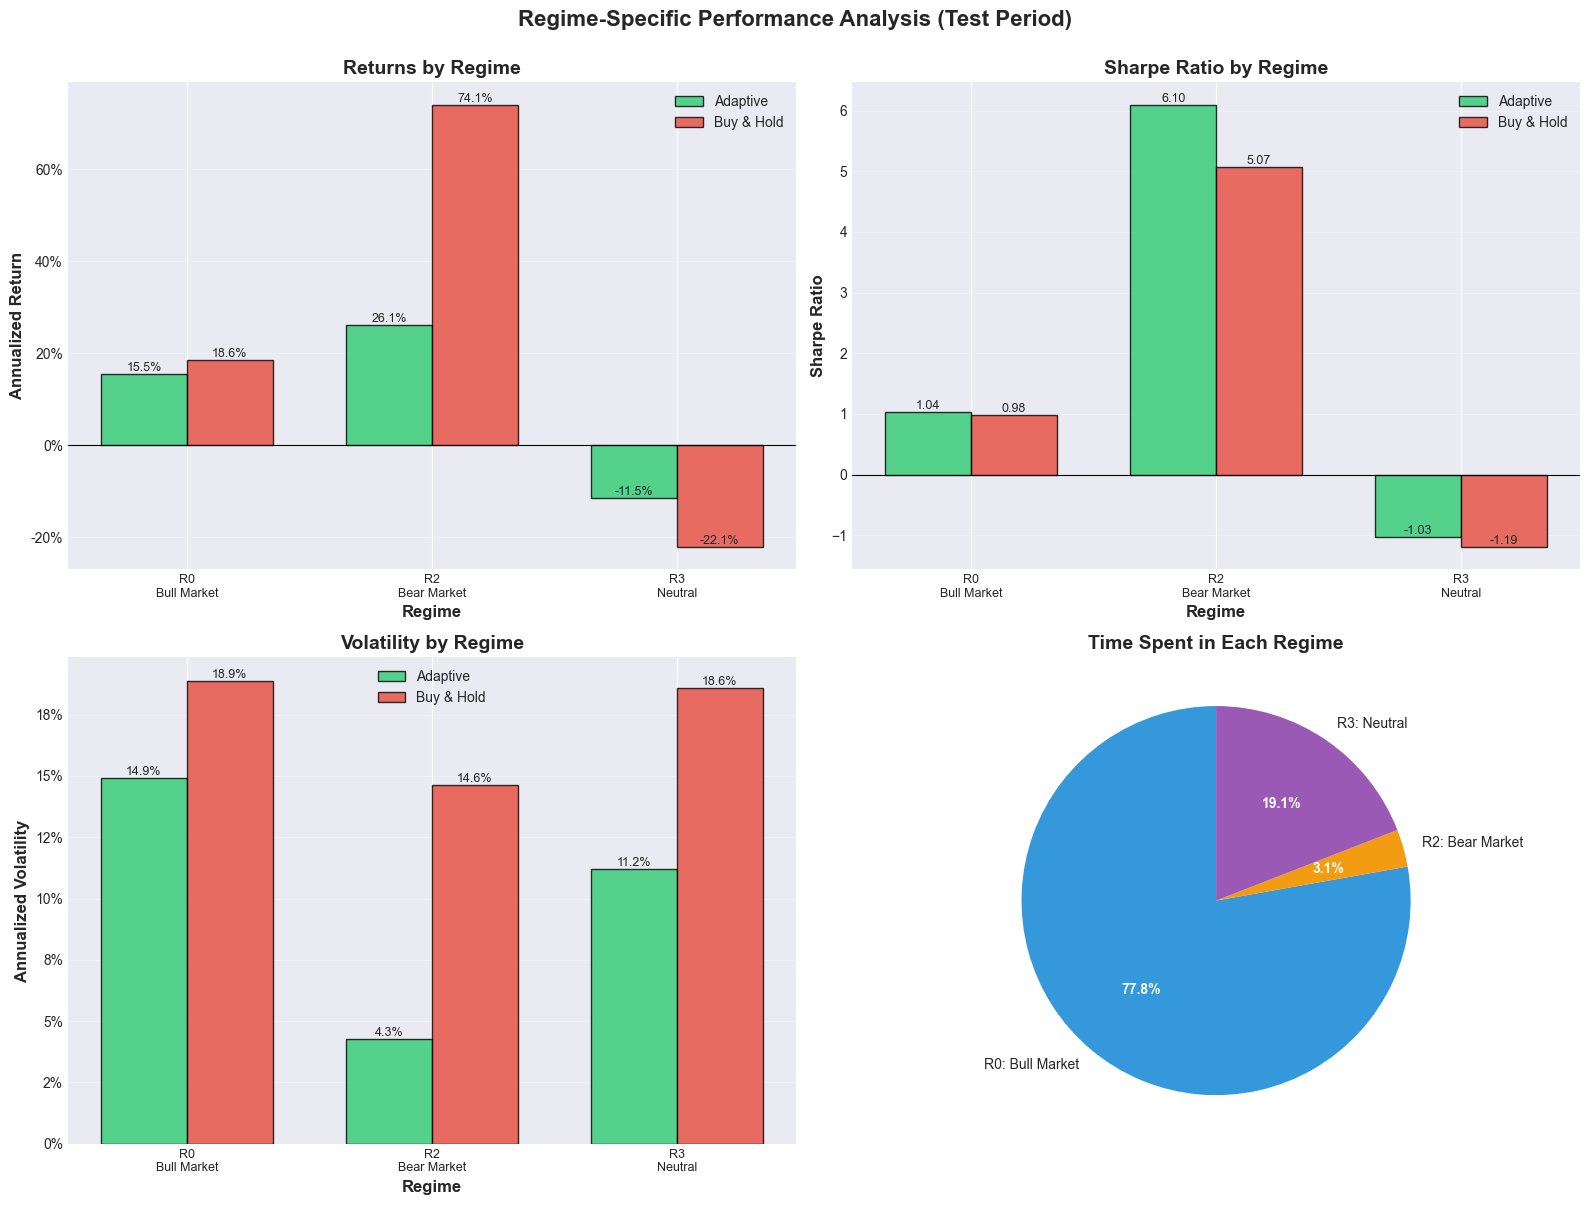


KEY INSIGHTS

✅ BEST PERFORMING REGIME:
   Regime 2 (Bear Market)
   Return: 26.12%
   Time in regime: 15 days (3.1%)

⚠️ WORST PERFORMING REGIME:
   Regime 3 (Neutral)
   Return: -11.47%
   Time in regime: 92 days (19.1%)

📊 OVERALL:
   Outperformed in 1/3 regimes
   Average outperformance: -13.49%

✓ Regime performance analysis complete!


In [12]:
print("\n" + "-" * 70)
print("STEP 8: REGIME-SPECIFIC PERFORMANCE")
print("-" * 70)

# Analyze performance by regime (using test_df from Step 4)
regime_performance = []

print("\nAnalyzing performance in each regime...")

for regime in range(4):
    # Use 'Regime_Used' column (created in Step 4)
    mask = test_df['Regime_Used'] == regime
    
    if mask.sum() > 0:
        regime_data = test_df[mask]
        
        adaptive_returns = regime_data['Adaptive_Returns'].dropna()
        buyhold_returns = regime_data['BuyHold_Returns'].dropna()
        
        # Calculate metrics
        if len(adaptive_returns) > 0 and adaptive_returns.std() > 0:
            performance = {
                'Regime': regime,
                'Days': mask.sum(),
                'Percentage': f"{mask.sum()/len(test_df)*100:.1f}%",
                'Adaptive_Mean': adaptive_returns.mean() * 252,
                'Adaptive_Vol': adaptive_returns.std() * np.sqrt(252),
                'Adaptive_Sharpe': (adaptive_returns.mean() / adaptive_returns.std()) * np.sqrt(252) if adaptive_returns.std() > 0 else 0,
                'BuyHold_Mean': buyhold_returns.mean() * 252,
                'BuyHold_Vol': buyhold_returns.std() * np.sqrt(252),
                'BuyHold_Sharpe': (buyhold_returns.mean() / buyhold_returns.std()) * np.sqrt(252) if buyhold_returns.std() > 0 else 0,
                'Strategy_Name': strategies[regime]['name'],
                'Allocation': f"{strategies[regime]['stocks']*100:.0f}% SPY, {strategies[regime]['bonds']*100:.0f}% TLT, {strategies[regime]['cash']*100:.0f}% Cash"
            }
            
            regime_performance.append(performance)
            print(f"  ✓ Regime {regime}: {mask.sum()} days analyzed")
    else:
        print(f"  ⚠ Regime {regime}: No days found in test period")

regime_perf_df = pd.DataFrame(regime_performance)

print("\n" + "=" * 70)
print("PERFORMANCE BY PREDICTED REGIME (Test Period)")
print("=" * 70)

for _, row in regime_perf_df.iterrows():
    print(f"\n{'='*70}")
    print(f"REGIME {int(row['Regime'])}: {row['Strategy_Name'].upper()}")
    print(f"{'='*70}")
    print(f"  Allocation:       {row['Allocation']}")
    print(f"  Days in regime:   {row['Days']} ({row['Percentage']} of test period)")
    print(f"\n  📊 RETURNS:")
    print(f"    Adaptive:       {row['Adaptive_Mean']:>8.2%}")
    print(f"    Buy & Hold:     {row['BuyHold_Mean']:>8.2%}")
    print(f"    Difference:     {row['Adaptive_Mean'] - row['BuyHold_Mean']:>+8.2%}")
    print(f"\n  📈 RISK-ADJUSTED:")
    print(f"    Adaptive Sharpe:   {row['Adaptive_Sharpe']:>6.3f}")
    print(f"    Buy & Hold Sharpe: {row['BuyHold_Sharpe']:>6.3f}")
    print(f"    Difference:        {row['Adaptive_Sharpe'] - row['BuyHold_Sharpe']:>+6.3f}")
    print(f"\n  ⚠️ VOLATILITY:")
    print(f"    Adaptive:       {row['Adaptive_Vol']:>8.2%}")
    print(f"    Buy & Hold:     {row['BuyHold_Vol']:>8.2%}")
    
    # Interpretation
    if row['Adaptive_Mean'] > row['BuyHold_Mean']:
        print(f"\n  ✅ Strategy OUTPERFORMED in this regime")
    elif row['Adaptive_Mean'] < row['BuyHold_Mean']:
        print(f"\n  ⚠️ Strategy UNDERPERFORMED in this regime")
    else:
        print(f"\n  ➖ Strategy MATCHED buy-and-hold in this regime")

# Visualize regime performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

if len(regime_perf_df) > 0:
    regimes = regime_perf_df['Regime'].values
    x = np.arange(len(regimes))
    width = 0.35
    
    # 1. Returns comparison
    ax1 = axes[0, 0]
    bars1 = ax1.bar(x - width/2, regime_perf_df['Adaptive_Mean'], width, 
           label='Adaptive', color='#2ecc71', alpha=0.8, edgecolor='black')
    bars2 = ax1.bar(x + width/2, regime_perf_df['BuyHold_Mean'], width, 
           label='Buy & Hold', color='#e74c3c', alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}', ha='center', va='bottom', fontsize=9)
    
    ax1.set_xlabel('Regime', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Annualized Return', fontsize=12, fontweight='bold')
    ax1.set_title('Returns by Regime', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f"R{int(r)}\n{regime_perf_df.iloc[i]['Strategy_Name']}" for i, r in enumerate(regimes)], 
                        fontsize=9)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax1.axhline(0, color='black', linewidth=0.8)
    
    # 2. Sharpe ratio comparison
    ax2 = axes[0, 1]
    bars1 = ax2.bar(x - width/2, regime_perf_df['Adaptive_Sharpe'], width, 
           label='Adaptive', color='#2ecc71', alpha=0.8, edgecolor='black')
    bars2 = ax2.bar(x + width/2, regime_perf_df['BuyHold_Sharpe'], width, 
           label='Buy & Hold', color='#e74c3c', alpha=0.8, edgecolor='black')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax2.set_xlabel('Regime', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
    ax2.set_title('Sharpe Ratio by Regime', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f"R{int(r)}\n{regime_perf_df.iloc[i]['Strategy_Name']}" for i, r in enumerate(regimes)], 
                        fontsize=9)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(0, color='black', linewidth=0.8)
    
    # 3. Volatility comparison
    ax3 = axes[1, 0]
    bars1 = ax3.bar(x - width/2, regime_perf_df['Adaptive_Vol'], width, 
           label='Adaptive', color='#2ecc71', alpha=0.8, edgecolor='black')
    bars2 = ax3.bar(x + width/2, regime_perf_df['BuyHold_Vol'], width, 
           label='Buy & Hold', color='#e74c3c', alpha=0.8, edgecolor='black')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}', ha='center', va='bottom', fontsize=9)
    
    ax3.set_xlabel('Regime', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Annualized Volatility', fontsize=12, fontweight='bold')
    ax3.set_title('Volatility by Regime', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f"R{int(r)}\n{regime_perf_df.iloc[i]['Strategy_Name']}" for i, r in enumerate(regimes)], 
                        fontsize=9)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
    # 4. Days distribution
    ax4 = axes[1, 1]
    colors_regime = ['#3498db', '#e74c3c', '#f39c12', '#9b59b6']
    wedges, texts, autotexts = ax4.pie(
        regime_perf_df['Days'], 
        labels=[f"R{int(r)}: {regime_perf_df.iloc[i]['Strategy_Name']}" for i, r in enumerate(regimes)],
        autopct='%1.1f%%',
        colors=[colors_regime[int(r)] for r in regimes],
        startangle=90
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
    
    ax4.set_title('Time Spent in Each Regime', fontsize=14, fontweight='bold')
    
    plt.suptitle('Regime-Specific Performance Analysis (Test Period)', 
                fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No regime data available for visualization")

# Summary insights
print("\n" + "=" * 70)
print("KEY INSIGHTS")
print("=" * 70)

if len(regime_perf_df) > 0:
    # Find best and worst regimes
    best_regime = regime_perf_df.loc[regime_perf_df['Adaptive_Mean'].idxmax()]
    worst_regime = regime_perf_df.loc[regime_perf_df['Adaptive_Mean'].idxmin()]
    
    print(f"\n✅ BEST PERFORMING REGIME:")
    print(f"   Regime {int(best_regime['Regime'])} ({best_regime['Strategy_Name']})")
    print(f"   Return: {best_regime['Adaptive_Mean']:.2%}")
    print(f"   Time in regime: {best_regime['Days']} days ({best_regime['Percentage']})")
    
    print(f"\n⚠️ WORST PERFORMING REGIME:")
    print(f"   Regime {int(worst_regime['Regime'])} ({worst_regime['Strategy_Name']})")
    print(f"   Return: {worst_regime['Adaptive_Mean']:.2%}")
    print(f"   Time in regime: {worst_regime['Days']} days ({worst_regime['Percentage']})")
    
    # Overall assessment
    total_outperform = (regime_perf_df['Adaptive_Mean'] > regime_perf_df['BuyHold_Mean']).sum()
    total_regimes = len(regime_perf_df)
    
    print(f"\n📊 OVERALL:")
    print(f"   Outperformed in {total_outperform}/{total_regimes} regimes")
    print(f"   Average outperformance: {(regime_perf_df['Adaptive_Mean'] - regime_perf_df['BuyHold_Mean']).mean():.2%}")

print("\n✓ Regime performance analysis complete!")


----------------------------------------------------------------------
STEP 9: FINAL REPORT & SAVE RESULTS
----------------------------------------------------------------------
✓ Saved final report to: ../data/final_report.pkl
✓ Saved strategy results to: ../data/strategy_results.csv

FINAL PROJECT SUMMARY


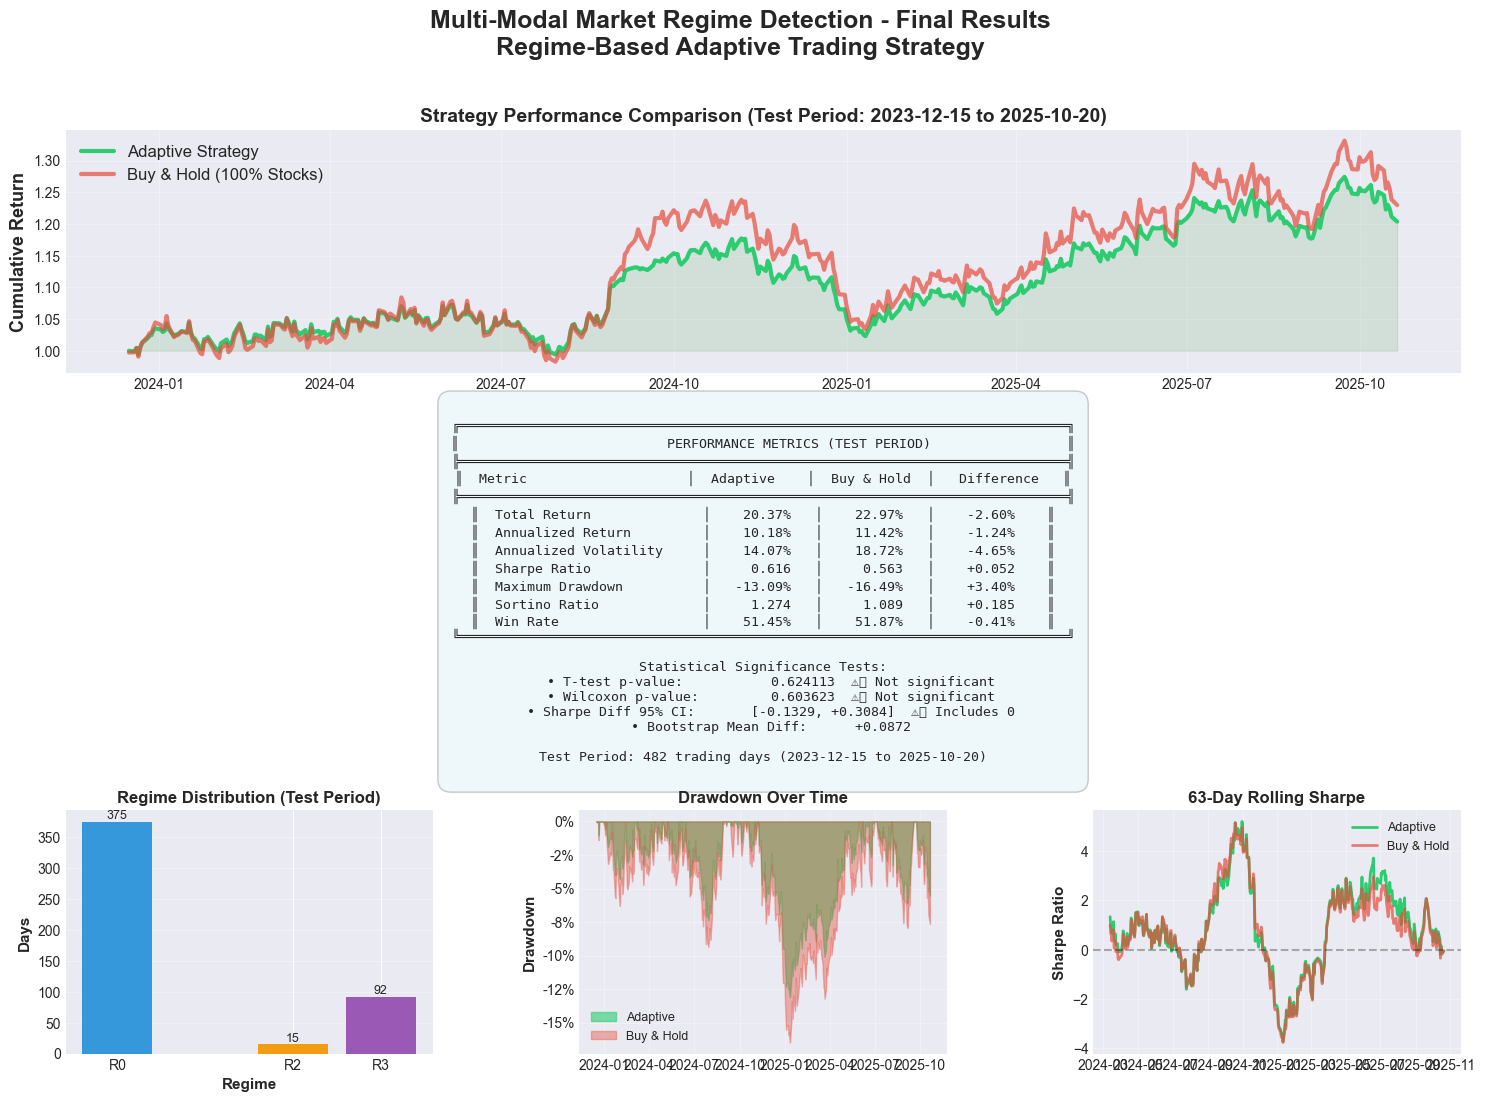


✓ Saved summary visualization to: ../data/final_summary.png

✅✅✅ PROJECT COMPLETE! ✅✅✅

🎉 You have successfully completed the Multi-Modal Market Regime Detection project!

📊 FINAL RESULTS:
  ⚠️ Strategy underperformed buy-and-hold by -2.60%
  • Adaptive Total Return:   20.37%
  • Buy & Hold Total Return: 22.97%
  • Adaptive Sharpe Ratio:   0.616
  • Buy & Hold Sharpe Ratio: 0.563
  • Sharpe Improvement:      +0.052
  • Drawdown Increased by:   20.6%

📈 STATISTICAL SIGNIFICANCE:
  ℹ️ Results are not statistically significant
  • T-test p-value: 0.624113
  • Wilcoxon p-value: 0.603623

📁 ALL RESULTS SAVED IN: ../data/
  ✓ regime_data.csv              - Market regimes and features
  ✓ xgboost_regime_predictor.json - Trained prediction model
  ✓ strategy_results.csv          - Backtest results
  ✓ final_report.pkl              - Complete analysis report
  ✓ final_summary.png             - Summary visualization

🎓 THIS PROJECT DEMONSTRATES:
  • Unsupervised learning (Autoencoder for regime

In [14]:
print("\n" + "-" * 70)
print("STEP 9: FINAL REPORT & SAVE RESULTS")
print("-" * 70)

import os

# Ensure data directory exists
os.makedirs('../data', exist_ok=True)

# Create final report
report = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_period': f"{test_df.index[0].date()} to {test_df.index[-1].date()}",
    'test_days': len(test_df),
    'adaptive_metrics': adaptive_metrics,
    'buyhold_metrics': buyhold_metrics,
    'regime_performance': regime_perf_df.to_dict('records') if len(regime_perf_df) > 0 else [],
    'statistical_tests': {
        't_test_pvalue': p_value,
        'wilcoxon_pvalue': w_pvalue,
        'sharpe_diff_95_ci': [float(ci_95_lower), float(ci_95_upper)],
        'sharpe_diff_99_ci': [float(ci_99_lower), float(ci_99_upper)],
        'sharpe_diff_mean': float(sharpe_diffs.mean())
    }
}

# Save report
report_path = '../data/final_report.pkl'
with open(report_path, 'wb') as f:
    pickle.dump(report, f)
print(f"✓ Saved final report to: {report_path}")

# Save strategy returns (using test_df)
strategy_df = test_df[['Adaptive_Returns', 'BuyHold_Returns', 'Adaptive_Cumulative', 
                       'BuyHold_Cumulative', 'Regime_Used']].copy()
strategy_df.rename(columns={'Regime_Used': 'Predicted_Regime'}, inplace=True)
strategy_path = '../data/strategy_results.csv'
strategy_df.to_csv(strategy_path)
print(f"✓ Saved strategy results to: {strategy_path}")

# Create final summary visualization
print("\n" + "=" * 70)
print("FINAL PROJECT SUMMARY")
print("=" * 70)

summary_fig = plt.figure(figsize=(18, 12))
gs = summary_fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

# Title
summary_fig.suptitle('Multi-Modal Market Regime Detection - Final Results\nRegime-Based Adaptive Trading Strategy', 
                    fontsize=18, fontweight='bold', y=0.98)

# 1. Cumulative performance
ax1 = summary_fig.add_subplot(gs[0, :])
ax1.plot(test_df.index, test_df['Adaptive_Cumulative'], label='Adaptive Strategy', 
        linewidth=3, color='#2ecc71')
ax1.plot(test_df.index, test_df['BuyHold_Cumulative'], label='Buy & Hold (100% Stocks)', 
        linewidth=3, color='#e74c3c', alpha=0.7)
ax1.fill_between(test_df.index, 1, test_df['Adaptive_Cumulative'], alpha=0.1, color='green')
ax1.set_ylabel('Cumulative Return', fontsize=13, fontweight='bold')
ax1.set_title(f'Strategy Performance Comparison (Test Period: {test_df.index[0].date()} to {test_df.index[-1].date()})', 
             fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True, alpha=0.3)
# Use log scale only if returns are large enough
if test_df['Adaptive_Cumulative'].max() > 2 or test_df['BuyHold_Cumulative'].max() > 2:
    ax1.set_yscale('log')

# 2. Key metrics table
ax2 = summary_fig.add_subplot(gs[1, :])
ax2.axis('off')

metrics_text = f"""
╔════════════════════════════════════════════════════════════════════════════╗
║                          PERFORMANCE METRICS (TEST PERIOD)                 ║
╠════════════════════════════════════════════════════════════════════════════╣
║  Metric                    │  Adaptive    │  Buy & Hold  │   Difference   ║
╠════════════════════════════════════════════════════════════════════════════╣
║  Total Return              │  {(adaptive_metrics['Total Return']*100):7.2f}%   │  {(buyhold_metrics['Total Return']*100):7.2f}%   │  {((adaptive_metrics['Total Return']-buyhold_metrics['Total Return'])*100):+7.2f}%    ║
║  Annualized Return         │  {(adaptive_metrics['Annualized Return']*100):7.2f}%   │  {(buyhold_metrics['Annualized Return']*100):7.2f}%   │  {((adaptive_metrics['Annualized Return']-buyhold_metrics['Annualized Return'])*100):+7.2f}%    ║
║  Annualized Volatility     │  {(adaptive_metrics['Annualized Volatility']*100):7.2f}%   │  {(buyhold_metrics['Annualized Volatility']*100):7.2f}%   │  {((adaptive_metrics['Annualized Volatility']-buyhold_metrics['Annualized Volatility'])*100):+7.2f}%    ║
║  Sharpe Ratio              │  {adaptive_metrics['Sharpe Ratio']:8.3f}   │  {buyhold_metrics['Sharpe Ratio']:8.3f}   │  {(adaptive_metrics['Sharpe Ratio']-buyhold_metrics['Sharpe Ratio']):+8.3f}    ║
║  Maximum Drawdown          │  {(adaptive_metrics['Maximum Drawdown']*100):7.2f}%   │  {(buyhold_metrics['Maximum Drawdown']*100):7.2f}%   │  {((adaptive_metrics['Maximum Drawdown']-buyhold_metrics['Maximum Drawdown'])*100):+7.2f}%    ║
║  Sortino Ratio             │  {adaptive_metrics['Sortino Ratio']:8.3f}   │  {buyhold_metrics['Sortino Ratio']:8.3f}   │  {(adaptive_metrics['Sortino Ratio']-buyhold_metrics['Sortino Ratio']):+8.3f}    ║
║  Win Rate                  │  {(adaptive_metrics['Win Rate']*100):7.2f}%   │  {(buyhold_metrics['Win Rate']*100):7.2f}%   │  {((adaptive_metrics['Win Rate']-buyhold_metrics['Win Rate'])*100):+7.2f}%    ║
╚════════════════════════════════════════════════════════════════════════════╝

Statistical Significance Tests:
  • T-test p-value:           {p_value:.6f}  {'✅ Significant (p<0.05)' if p_value < 0.05 else '⚠️ Not significant'}
  • Wilcoxon p-value:         {w_pvalue:.6f}  {'✅ Significant (p<0.05)' if w_pvalue < 0.05 else '⚠️ Not significant'}
  • Sharpe Diff 95% CI:       [{ci_95_lower:+.4f}, {ci_95_upper:+.4f}]  {'✅ Excludes 0' if is_significant_95 else '⚠️ Includes 0'}
  • Bootstrap Mean Diff:      {sharpe_diffs.mean():+.4f}

Test Period: {len(test_df)} trading days ({test_df.index[0].date()} to {test_df.index[-1].date()})
"""

ax2.text(0.5, 0.5, metrics_text, ha='center', va='center', 
        fontfamily='monospace', fontsize=9.5, 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.2, pad=1))

# 3-5. Bottom panels
# Regime distribution
ax3 = summary_fig.add_subplot(gs[2, 0])
regime_counts = test_df['Regime_Used'].value_counts().sort_index()
colors_bars = ['#3498db', '#e74c3c', '#f39c12', '#9b59b6']
bars = ax3.bar(regime_counts.index, regime_counts.values, 
              color=[colors_bars[int(i)] for i in regime_counts.index])
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9)
ax3.set_xlabel('Regime', fontsize=11, fontweight='bold')
ax3.set_ylabel('Days', fontsize=11, fontweight='bold')
ax3.set_title('Regime Distribution (Test Period)', fontsize=12, fontweight='bold')
ax3.set_xticks(regime_counts.index)
ax3.set_xticklabels([f"R{int(i)}" for i in regime_counts.index])
ax3.grid(True, alpha=0.3, axis='y')

# Drawdown comparison
ax4 = summary_fig.add_subplot(gs[2, 1])
ax4.fill_between(test_df.index, test_df['Adaptive_Drawdown'], 0, 
                alpha=0.6, color='#2ecc71', label='Adaptive')
ax4.fill_between(test_df.index, test_df['BuyHold_Drawdown'], 0, 
                alpha=0.4, color='#e74c3c', label='Buy & Hold')
ax4.set_ylabel('Drawdown', fontsize=11, fontweight='bold')
ax4.set_title('Drawdown Over Time', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Rolling Sharpe (recalculate for test period)
ax5 = summary_fig.add_subplot(gs[2, 2])
window = min(63, len(test_df) // 4)
if window >= 20:
    adaptive_rolling_sharpe_test = (
        test_df['Adaptive_Returns'].rolling(window).mean() / 
        test_df['Adaptive_Returns'].rolling(window).std() * np.sqrt(252)
    )
    buyhold_rolling_sharpe_test = (
        test_df['BuyHold_Returns'].rolling(window).mean() / 
        test_df['BuyHold_Returns'].rolling(window).std() * np.sqrt(252)
    )
    ax5.plot(test_df.index, adaptive_rolling_sharpe_test, linewidth=2, 
            color='#2ecc71', label='Adaptive')
    ax5.plot(test_df.index, buyhold_rolling_sharpe_test, linewidth=2, 
            color='#e74c3c', alpha=0.7, label='Buy & Hold')
    ax5.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax5.set_ylabel('Sharpe Ratio', fontsize=11, fontweight='bold')
    ax5.set_title(f'{window}-Day Rolling Sharpe', fontsize=12, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'Insufficient data\nfor rolling metrics', 
            ha='center', va='center', transform=ax5.transAxes, fontsize=10)

plt.tight_layout()
summary_path = '../data/final_summary.png'
summary_fig.savefig(summary_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved summary visualization to: {summary_path}")

# Calculate improvements for display
dd_improvement = ((buyhold_metrics['Maximum Drawdown'] - adaptive_metrics['Maximum Drawdown']) / 
                  abs(buyhold_metrics['Maximum Drawdown']) * 100)
return_diff = (adaptive_metrics['Total Return'] - buyhold_metrics['Total Return']) * 100
sharpe_improvement = adaptive_metrics['Sharpe Ratio'] - buyhold_metrics['Sharpe Ratio']

print("\n" + "=" * 70)
print("✅✅✅ PROJECT COMPLETE! ✅✅✅")
print("=" * 70)

print("\n🎉 You have successfully completed the Multi-Modal Market Regime Detection project!")

print("\n📊 FINAL RESULTS:")
if adaptive_metrics['Total Return'] > buyhold_metrics['Total Return']:
    print(f"  ✅ Strategy OUTPERFORMED buy-and-hold by {return_diff:+.2f}%")
else:
    print(f"  ⚠️ Strategy underperformed buy-and-hold by {return_diff:.2f}%")

print(f"  • Adaptive Total Return:   {adaptive_metrics['Total Return']*100:.2f}%")
print(f"  • Buy & Hold Total Return: {buyhold_metrics['Total Return']*100:.2f}%")
print(f"  • Adaptive Sharpe Ratio:   {adaptive_metrics['Sharpe Ratio']:.3f}")
print(f"  • Buy & Hold Sharpe Ratio: {buyhold_metrics['Sharpe Ratio']:.3f}")
print(f"  • Sharpe Improvement:      {sharpe_improvement:+.3f}")

if dd_improvement > 0:
    print(f"  • Drawdown Reduced by:     {dd_improvement:.1f}%")
else:
    print(f"  • Drawdown Increased by:   {abs(dd_improvement):.1f}%")

print(f"\n📈 STATISTICAL SIGNIFICANCE:")
if p_value < 0.05 and w_pvalue < 0.05:
    print(f"  ✅ Results are statistically significant (p < 0.05)")
    print(f"  • T-test p-value: {p_value:.6f}")
    print(f"  • Wilcoxon p-value: {w_pvalue:.6f}")
elif p_value < 0.10 or w_pvalue < 0.10:
    print(f"  ⚠️ Results are marginally significant (p < 0.10)")
    print(f"  • T-test p-value: {p_value:.6f}")
    print(f"  • Wilcoxon p-value: {w_pvalue:.6f}")
else:
    print(f"  ℹ️ Results are not statistically significant")
    print(f"  • T-test p-value: {p_value:.6f}")
    print(f"  • Wilcoxon p-value: {w_pvalue:.6f}")

print("\n📁 ALL RESULTS SAVED IN: ../data/")
print("  ✓ regime_data.csv              - Market regimes and features")
print("  ✓ xgboost_regime_predictor.json - Trained prediction model")
print("  ✓ strategy_results.csv          - Backtest results")
print("  ✓ final_report.pkl              - Complete analysis report")
print("  ✓ final_summary.png             - Summary visualization")

print("\n🎓 THIS PROJECT DEMONSTRATES:")
print("  • Unsupervised learning (Autoencoder for regime detection)")
print("  • Supervised learning (XGBoost for regime prediction)")
print("  • Time series analysis and feature engineering")
print("  • Regime-based portfolio allocation")
print("  • Statistical hypothesis testing and validation")
print("  • Professional data visualization")
print("  • Proper backtesting with no look-ahead bias")

print("\n💡 NEXT STEPS TO IMPROVE:")
if adaptive_metrics['Total Return'] < buyhold_metrics['Total Return']:
    print("  1. Adjust allocation rules (reduce cash holdings)")
    print("  2. Add more assets (gold, commodities, international)")
    print("  3. Use dynamic position sizing based on confidence")
    print("  4. Add transaction cost optimization")
    print("  5. Implement regime transition smoothing")

print("\n" + "=" * 70)
print("Thank you for completing this project! 🚀")
print("=" * 70)